# Radiaoctivity

The aipha decay was discovered in 1899 by Rutherford [E. Rutherford Viii. Uranium radiation and the electrical conduction produced by it Philos. Mag. Ser. 5, 47 (284) (1899), pp. 109-163, 10.1080/14786449908621245] and was explained theoretivally by Gamov in 1928 using the quantum mechanical tunneling theory [G. Gamow Zur quantentheorie des atomkernes Z. Phys., 51 (1928), pp. 204-212, 10.1007/BF01343196]. After four years 14C radioactivity of 223Ra was observed experimentally by Rose and Jones[H. Rose, G. JonesA new kind of natural radioactivity Nature, 307 (1984), pp. 245-247, 10.1038/307245a0]




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import brentq
from dataclasses import dataclass


# -----------------------------------------------------------------------------
# 1. Global Definitions and Parameters (in atomic units)
# -----------------------------------------------------------------------------
ALPHA_MASS_AU = 7294.0     # alpha particle mass in me
AU_TIME_TO_S = 1  # 1 a.u. of time -> seconds


# -----------------------------
# Input Parameters
# -----------------------------
Z_parent    = 84          # parent nucleus charge (Polonium)
E_hartree   = 5.5e5       # alpha particle energy for Polonium (Hartree) ~ 5 MeV => ~ 1.84e5 Hartree
V0_hartree  = 4.3e6       # Woods-Saxon depth (not the actual well depth below 0) ~ 50 MeV => ~ 1.84e6 Hartree
R0_bohr     = 13.7e-5     # ~ 5 fm => ~ 9.45e-5 Bohr
a_bohr      = 1.3e-5      # diffuseness (Bohr) ~ 0.65 fm => ~ 1.23e-5 Bohr
l_orbital   = 0           # orbital angular momentum
r_min       = 1e-6        # inner bohr-radius
r_max       = 5e-3        # outer bohr-radius
N           = 2000        # number of points for scanning turning points


Troubleshooting Info:
  r_min = 1e-06, r_max = 0.005
  V_min over this range = -2.3829e+06 Hartree
  V_max over this range = 1.6370e+08 Hartree
  E (alpha energy)      = 5.5000e+05 Hartree

Sample checks of sign(E - V(r)) at a few points:
  r=1.0000e-06, V(r)=1.6370e+08, E-V=-1.6315e+08 (-)
  r=2.5018e-03, V(r)=6.7153e+04, E-V=4.8285e+05 (+)
  r=5.0000e-03, V(r)=3.3600e+04, E-V=5.1640e+05 (+)

-- Attempting to detect barrier & compute WKB --
Turning points found (Bohr radii): [3.465087209402338e-05, 0.00016416933480219474, 0.0003054489138874367]
Barrier region: r_in=1.6417e-04, r_out=3.0545e-04

-- Results --
WKB barrier integral = 6.034312e+00
Tunneling probability = 5.737e-06
Well region: r_a=3.4651e-05, r_b=1.6417e-04
Classical period T_au = 1.6301e-05 => T_s=1.6301e-05 s
Decay rate Gamma = 3.5193e-01 s^-1
Half-life t_1/2 = 1.9695e+00 s


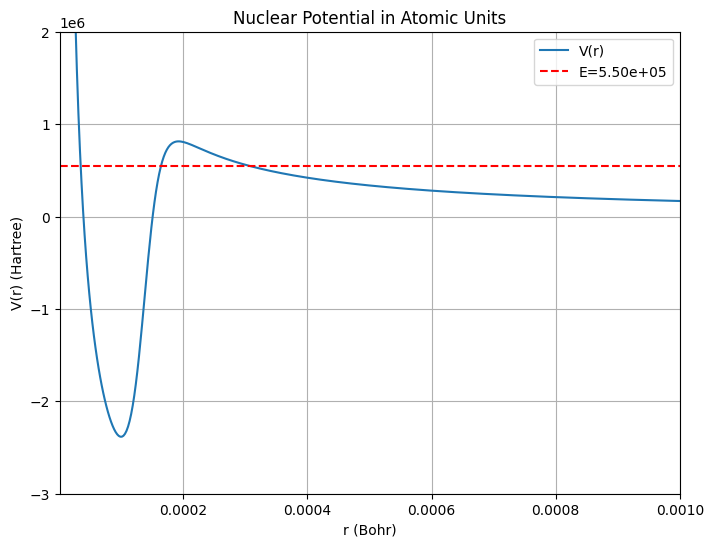

In [9]:
# -----------------------------------------------------------------------------
# 2. Potential: Woods-Saxon + Coulomb in a.u.
# -----------------------------------------------------------------------------
def V_WS_Coulomb_au(r, V0, R0, a, Z_nuc, Zalpha=2, mass_alpha=ALPHA_MASS_AU, l=0):
    """
    Woods-Saxon + Coulomb + optional centrifugal term in atomic units.
    """
    if r < 1e-12:
        r = 1e-12
    
    # Woods-Saxon
    Vws = -V0 / (1.0 + np.exp((r - R0)/a))
    # Coulomb
    Vcoul = Zalpha * Z_nuc / r
    # Centrifugal
    Vcentrif = l*(l+1)/(2.0*mass_alpha*r*r)
    return Vws + Vcoul + Vcentrif

# Potential Wrapper
def potential_au(r):
    return V_WS_Coulomb_au(r,
                           V0=V0_hartree,
                           R0=R0_bohr,
                           a=a_bohr,
                           Z_nuc=Z_parent,
                           Zalpha=2,
                           mass_alpha=ALPHA_MASS_AU,
                           l=l_orbital)

# -----------------------------------------------------------------------------
# 3. WKB and Classical Integrand Functions
# -----------------------------------------------------------------------------
def forbidden_integrand(r, E, m_alpha, pot_func):
    """
    Calculates the square root for the WKB integral
    sqrt(2*m_alpha*(V(r)-E)) if V(r)>E, else 0
    """
    val = pot_func(r) - E
    return np.sqrt(2*m_alpha*val) if val > 0 else 0.0

def classical_integrand(r, E, m_alpha, pot_func):
    """
    Calculates inverse velocity in the classical region
    1 / v(r) = sqrt(m_alpha/(2*(E - V(r)))) if E>V(r), else 0
    """
    val = E - pot_func(r)
    return np.sqrt(m_alpha/(2*val)) if val > 0 else 0.0

# -----------------------------------------------------------------------------
# 4. Helper Functions
# -----------------------------------------------------------------------------
def find_turning_points(r_min, r_max, E, pot_func, N=2000):
    r_vals = np.linspace(r_min, r_max, N)
    diff = E - np.array([pot_func(rv) for rv in r_vals])
    
    turning_pts = []
    for i in range(len(r_vals)-1):
        if diff[i]*diff[i+1] < 0:
            root = brentq(lambda rr: E - pot_func(rr), r_vals[i], r_vals[i+1])
            turning_pts.append(root)
    turning_pts.sort()
    return turning_pts

def detect_barrier_hill(E, turning_points, r_min, r_max, pot_func):
    """
    Looks for the pattern (+)->(-)->(+) in E-V(r)
    Returns the last such (r_in, r_out) if found
    """
    boundaries = [r_min] + turning_points + [r_max]
    signs = []
    for i in range(len(boundaries)-1):
        mid = 0.5*(boundaries[i] + boundaries[i+1])
        val_mid = E - pot_func(mid)
        s = 1 if val_mid > 0 else -1
        signs.append(s)
    
    hill_intervals = []
    for i in range(len(signs)-2):
        if signs[i] == 1 and signs[i+1] == -1 and signs[i+2] == 1:
            hill_start = boundaries[i+1]
            hill_end   = boundaries[i+2]
            hill_intervals.append((hill_start, hill_end))
    
    if hill_intervals:
        return hill_intervals[-1]
    return None

def compute_WKB_barrier_integral(r_in, r_out, E, m_alpha, pot_func):
    val, _ = quad(lambda rr: forbidden_integrand(rr, E, m_alpha, pot_func),
                  r_in, r_out, epsabs=1e-12, epsrel=1e-12, limit=1000)
    return val

def find_well_region(E, turning_points, r_min, r_max, pot_func):
    """
    Finds the first sub-interval [r_a, r_b] where E>V(r)
    """
    boundaries = [r_min] + turning_points + [r_max]
    for i in range(len(boundaries)-1):
        left = boundaries[i]
        right = boundaries[i+1]
        mid = 0.5*(left + right)
        if (E - pot_func(mid)) > 0:
            return (left, right)
    return None

def compute_classical_period(r_a, r_b, E, m_alpha, pot_func):
    single_trip, _ = quad(lambda rr: classical_integrand(rr, E, m_alpha, pot_func),
                          r_a, r_b, epsabs=1e-12, epsrel=1e-12, limit=1000)
    return 2.0 * single_trip

# -----------------------------------------------------------------------------
# 5. Troubleshooting
# -----------------------------------------------------------------------------

# Evaluates the potential on a grid to see if there's a barrier above E
r_dense = np.linspace(r_min, r_max, 2000)
V_dense = np.array([potential_au(rv) for rv in r_dense])

# Prints min/max of potential
V_min = np.min(V_dense)
V_max = np.max(V_dense)
print("Troubleshooting Info:")
print(f"  r_min = {r_min}, r_max = {r_max}")
print(f"  V_min over this range = {V_min:.4e} Hartree")
print(f"  V_max over this range = {V_max:.4e} Hartree")
print(f"  E (alpha energy)      = {E_hartree:.4e} Hartree")

# Checks if E is bigger than V_max or smaller than V_min
if E_hartree > V_max:
    print("E is ABOVE the maximum potential => no barrier (region with V>E)")
if E_hartree < V_min:
    print("E is BELOW the entire potential => might only have 1 crossing or none")

# Sample a few points in E - V(r) to determine sign
sample_indices = [0, len(r_dense)//2, len(r_dense)-1]
print("\nSample checks of sign(E - V(r)) at a few points:")
for idx in sample_indices:
    rr = r_dense[idx]
    val = E_hartree - V_dense[idx]
    sign_str = "+" if val>0 else "-"
    print(f"  r={rr:.4e}, V(r)={V_dense[idx]:.4e}, E-V={val:.4e} ({sign_str})")

# -----------------------------------------------------------------------------
# 6. Main Calculation
# -----------------------------------------------------------------------------
print("\n-- Attempting to detect barrier & compute WKB --")

turning_pts = find_turning_points(r_min, r_max, E_hartree, potential_au, N=N)
print(f"Turning points found (Bohr radii): {turning_pts}")

barrier = detect_barrier_hill(E_hartree, turning_pts, r_min, r_max, potential_au)
if barrier is None:
    raise ValueError("No barrier (hill) detected.")
r_in, r_out = barrier
print(f"Barrier region: r_in={r_in:.4e}, r_out={r_out:.4e}")

barrier_integral = compute_WKB_barrier_integral(r_in, r_out, E_hartree, ALPHA_MASS_AU, potential_au)
P_tunnel = np.exp(-2.0 * barrier_integral)

well_region = find_well_region(E_hartree, turning_pts, r_min, r_max, potential_au)
if well_region is None:
    raise ValueError("No well region found (E < V everywhere?).")
r_a, r_b = well_region
T_au = compute_classical_period(r_a, r_b, E_hartree, ALPHA_MASS_AU, potential_au)
T_s = T_au * AU_TIME_TO_S
Gamma_s = (1.0 / T_s) * P_tunnel
t_half_s = np.log(2) / Gamma_s

print("\n-- Results --")
print(f"WKB barrier integral = {barrier_integral:.6e}")
print(f"Tunneling probability = {P_tunnel:.3e}")
print(f"Well region: r_a={r_a:.4e}, r_b={r_b:.4e}")
print(f"Classical period T_au = {T_au:.4e} => T_s={T_s:.4e} s")
print(f"Decay rate Gamma = {Gamma_s:.4e} s^-1")
print(f"Half-life t_1/2 = {t_half_s:.4e} s")

# -----------------------------------------------------------------------------
# 7. Plot
# -----------------------------------------------------------------------------
plt.figure(figsize=(8,6))
plt.plot(r_dense, V_dense, label='V(r)')
plt.axhline(E_hartree, color='r', linestyle='--', label=f'E={E_hartree:.2e}')
plt.xlabel('r (Bohr)')
plt.ylabel('V(r) (Hartree)')
plt.title('Nuclear Potential in Atomic Units')
plt.grid(True)
plt.legend()
plt.xlim(1e-6, 1e-3)
plt.ylim(-3e6, 2e6)
plt.show()

# Literature value for Ra-226: 1600 year = 5e+10 s
